In [125]:
import pandas as pd
import numpy as np
import nltk
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import time
from sklearn.linear_model import LogisticRegression


In [92]:
# DATA LOADING FUNCTIONS

# split dataset
def split_dataset(full_data, train_ratio, validation_ratio, test_ratio):
    """
    Function that splits the dataset into train, validation, and test
    """
    random_idx = np.random.permutation(len(full_data))
    train_threshold = int(round(train_ratio*len(full_data)))
    validation_threshold = int(round((train_ratio+validation_ratio)*len(full_data)))
    
    train_set = full_data.iloc[random_idx[:train_threshold]]
    validation_set = full_data.iloc[random_idx[train_threshold:validation_threshold]]
    test_set = full_data.iloc[random_idx[validation_threshold:]]
    
    return train_set, validation_set, test_set


# load dataset
def load_datasets(load_dir = "../data"):
    """
    Function that loads the dataset
    """
    train_set = pd.read_csv("../data/train.csv")
    validation_set = pd.read_csv("../data/validation.csv")
    test_set = pd.read_csv("../data/test.csv")
    return train_set, validation_set, test_set

def xy_split(df, label_col="is_duplicate"):
    """
    Function that splits a data frame into X and y
    """
    return df.drop(label_col, axis=1).as_matrix(), df[label_col]


In [93]:
# DATA CLEANING FUNCTIONS
def clean_str(input_str):
    """
    Helper function that converts string to ASCII
    """
    # trivial case
    if pd.isnull(input_str):
        return ""
    # encoding
    input_str = input_str.decode('ascii', 'ignore').lower()
    return input_str

def clean_dataset(full_dataset):
    """
    Function that cleans the full dataset
    """
    full_data["clean_q1"] = full_data["question1"].apply(clean_str,1)
    full_data["clean_q2"] = full_data["question2"].apply(clean_str,1)
    return full_dataset

In [117]:
# FEATURE ENGINEERING FUNCTIONS
def word_overlap(row):
    """
    Function that calculates the percentage of word overlap
    """
    token_1 = nltk.word_tokenize(row["clean_q1"])
    token_2 = nltk.word_tokenize(row["clean_q2"])
    avg_length = float(len(token_1)+len(token_2))/2
    save_token_num = len(set(token_1).intersection(set(token_2)))
    return float(save_token_num)/avg_length


def feature_engineering(df, top_k_word=500):
    """
    Feature engineering function
    """
    # length
    df["len_1"] = df["clean_q1"].apply(len)
    df["len_2"] = df["clean_q1"].apply(lambda x: len(str(x)))
    df["len_diff"] = np.abs(df["len_1"]-df["len_2"])
    print("length fueature loaded")
    
    # first words match
    df["first_word_q1"] = df.apply(lambda x: x["clean_q1"].split(" ")[0], 1)
    df["first_word_q2"] = df.apply(lambda x: x["clean_q2"].split(" ")[0], 1)
    df["first_word_match"] = (df["first_word_q1"] == df["first_word_q2"])
    print("first word feature loaded")
    
    # bag of words
    bag_of_word_tokenizer = CountVectorizer(stop_words="english", max_features=top_k_word)
    q1_matrix = bag_of_word_tokenizer.fit_transform(df["clean_q1"]).astype(np.float)
    q2_matrix = bag_of_word_tokenizer.fit_transform(df["clean_q2"]).astype(np.float)
    df["vec_q1"] = [q1_matrix[i] for i in range(len(df))]
    df["vec_q2"] = [q2_matrix[i] for i in range(len(df))]
    print("question vectorized")
    
    # similarity measure
    cosine_sim = [cosine_similarity(q1_matrix[i], q2_matrix[i])[0][0] for i in range(len(df))]
    df["cosine_sim"] = cosine_sim
    df["overlap_percent"] = df.apply(word_overlap, 1)
    print("similarity feature loaded")
    
    # filter columns
    ignore_columns = ["first_word_q1", "first_word_q2", "clean_q1", "clean_q2",
                     "id", "qid1", "qid2", "question1", "question2",
                     "vec_q1", "vec_q2"]
    full_feature_df = df
    clean_feature_df = df.drop(ignore_columns, axis=1)
    
    return full_feature_df, clean_feature_df
    


In [118]:
# DATA CREATION SCRIPTS
# full dataset 
full_data = pd.read_csv("../data/questions.csv")
print("data loaded")

# clean dataset
clean_df = clean_dataset(full_data)
print("data cleaned")

# feature engineering
full_feature_df, clean_feature_df = feature_engineering(clean_df)
print("data featurized")

# split and save dataset
train_set, validation_set, test_set = split_dataset(clean_feature_df, 0.8, 0.1, 0.1)
train_set.to_csv("../data/train.csv", index=False)
validation_set.to_csv("../data/validation.csv", index=False)
test_set.to_csv("../data/test.csv", index=False)
#full_feature_df.to_csv("../data/full_feature_df.csv", index=False)

# load splitted dataset
# train_set, validation_set, test_set = load_datasets()

# split X, y
X_train, y_train = xy_split(train_set)
X_validate, y_validate = xy_split(validation_set)
X_test, y_test = xy_split(test_set)

data loaded
data cleaned
length fueature loaded
first word feature loaded
question vectorized
similarity feature loaded
data featurized


In [121]:
#mat1 = full_feature_df["vec_q1"].iloc[0]
#mat2 = full_feature_df["vec_q2"].iloc[0]

#cosine_similarity(mat1[5], mat2[5])
#a = time.time()
#cosine_similarity(full_feature_df["vec_q1"].iloc[10],full_feature_df["vec_q2"].iloc[10] )
#print time.time()-a
#len(full_feature_df)
#full_feature_df.to_csv("../data/full_feature_df.csv", index=False)
#np.sum(clean_feature_df["cosine_sim"]==0)/float(len(clean_feature_df))

0.65178520641719695

In [100]:
#mat1 = mat1.astype(np.float)
#mat2 = mat2.astype(np.float)
#cosine_similarity(mat1, mat2)

array([[ 0.]])

In [25]:
# PREDICTIVE MODEL FUNCTIONS

In [128]:
# MODEL ANALYTICS FUNCTIONS
def all_test_metrics(y_pred, y_test, metrics_list=["acc", "auc", "f1", "nll"]):
    score_dict = {}
    # acc
    if "acc" in metrics_list:
        y_pred_acc = np.round(y_pred).astype(np.int8)
        acc = metrics.accuracy_score(y_test, y_pred_acc, normalize=True)
        score_dict["acc"] = acc 
    # auc
    if "auc" in metrics_list:
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        score_dict["auc"] = auc
        #score_dict["fpr"] = fpr
        #score_dict["tpr"] = tpr
    # f1-measure
    if "f1" in metrics_list:
        y_pred_acc = np.round(y_pred).astype(np.int8)
        f1 = metrics.f1_score(y_test, y_pred_acc, labels=[0,1], pos_label=1)
        score_dict["f1"] = f1
    # nll
    if "nll" in metrics_list:
        nll = metrics.log_loss(y_test, y_pred)
        score_dict["nll"] = nll
    return score_dict


def test_model(model, X_test, y_test, verbose=True, model_name="", y_pred_test=None):
    """
    Function that generate performance stats for a model
    """
    if y_pred_test is None:
        y_pred_test = model.predict(X_test)
    
    scores = all_test_metrics(y_pred_test, y_test)    
    if verbose:
        print(model_name+":")
        print(scores)
    return scores
    
    

In [129]:
# MODEL ANALYTICS SCRIPT
n_valid = len(validation_set)
n_test = len(test_set)

# baseline 1: majority class
y_pred_valid = [0 for i in range(n_valid)]
y_pred_test = [0 for i in range(n_test)]
score_majority_class_valid = test_model(None, None, y_validate, 
                                        verbose=True, model_name="Baseline 1 - Majority Class (Validation):",
                                        y_pred_test=y_pred_valid)
score_majority_class_valid = test_model(None, None, y_test, 
                                        verbose=True, model_name="Baseline 1 - Majority Class (Test):",
                                        y_pred_test=y_pred_test)

# baseline 2: simple word overlap
y_pred_valid = X_validate[:,5].astype(np.double)
y_pred_test = X_test[:,5].astype(np.double)
score_majority_class_valid = test_model(None, None, y_validate, 
                                        verbose=True, model_name="Baseline 2 - Simple Word Overlap (Validation):",
                                        y_pred_test=y_pred_valid)
score_majority_class_valid = test_model(None, None, y_test, 
                                        verbose=True, model_name="Baseline 2 - Simple Word Overlap (Test):",
                                        y_pred_test=y_pred_test)

# baseline 3: logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
score_majority_class_valid = test_model(lr, X_validate, y_valid, 
                                        verbose=True, model_name="Baseline 3 - Simple Logistic Regression (Validation):")
score_majority_class_valid = test_model(lr, X_test, y_test, 
                                        verbose=True, model_name="Baseline 3 - Simple Logistic Regression (Test):")


Baseline 1 - Majority Class (Validation)::
{'acc': 0.63121058488932857, 'f1': 0.0, 'auc': 0.5, 'nll': 12.737535145317379}
Baseline 1 - Majority Class (Test)::
{'acc': 0.62886113515518738, 'f1': 0.0, 'auc': 0.5, 'nll': 12.818682264335962}
Baseline 2 - Simple Word Overlap (Validation)::
{'acc': 0.67043402992457035, 'f1': 0.62008210742387959, 'auc': 0.73159265672853513, 'nll': 0.66327276288756387}
Baseline 2 - Simple Word Overlap (Test)::
{'acc': 0.67073080252256712, 'f1': 0.62154633314383168, 'auc': 0.73225478102353558, 'nll': 0.66252622910333181}
Baseline 3 - Simple Logistic Regression (Validation)::
{'acc': 0.65317175714109066, 'f1': 0.46680860771044025, 'auc': 0.6029729320659023, 'nll': 11.979126965458967}
Baseline 3 - Simple Logistic Regression (Test)::
{'acc': 0.65364164708791883, 'f1': 0.46876303910784051, 'auc': 0.60407336232447073, 'nll': 11.962896078313841}


In [102]:
row = full_data[(full_data["overlap_percent"] > 0.99) & full_data["is_duplicate"]==0].iloc[0]
print(row["question1"])
print(row["question2"])


What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?


In [106]:
len(full_data.columns)
np.sum(full_data["is_duplicate"])/float(len(full_data))

0.3692484994472624

In [48]:
import matplotlib.pyplot as plt

def draw_line_plot(x_list, y_list, title, x_label, y_label, label):
    for i in range(len(x_list)):
        plt.plot(x_list[i], y_list[i], label=label[i])
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

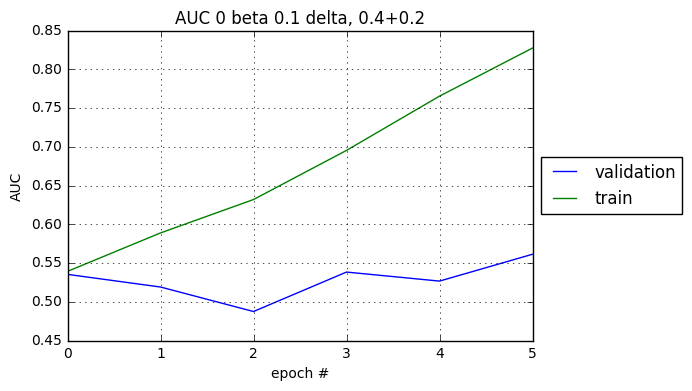

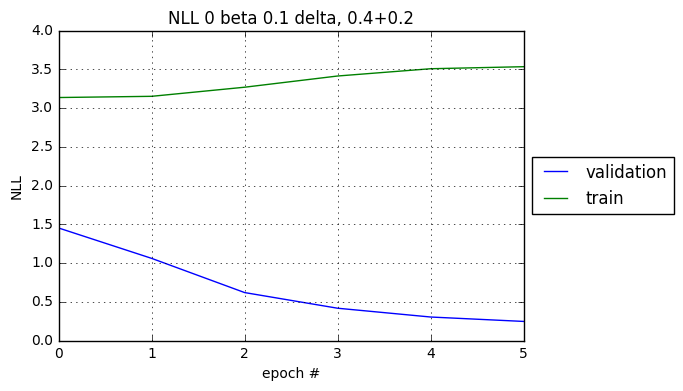

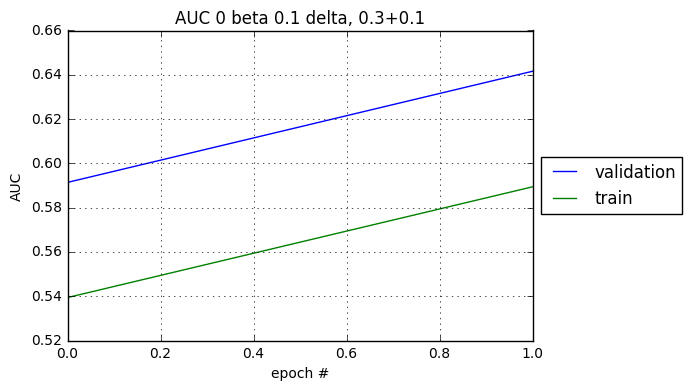

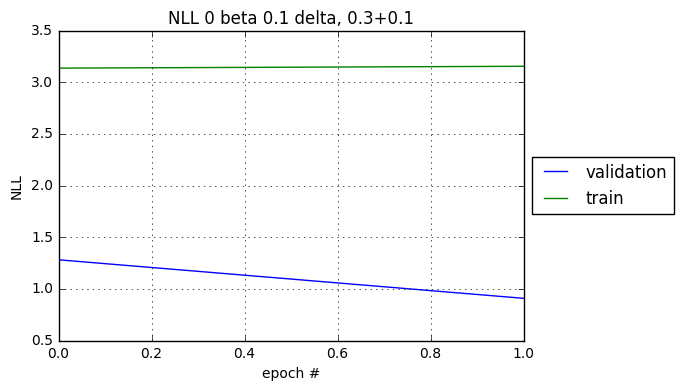

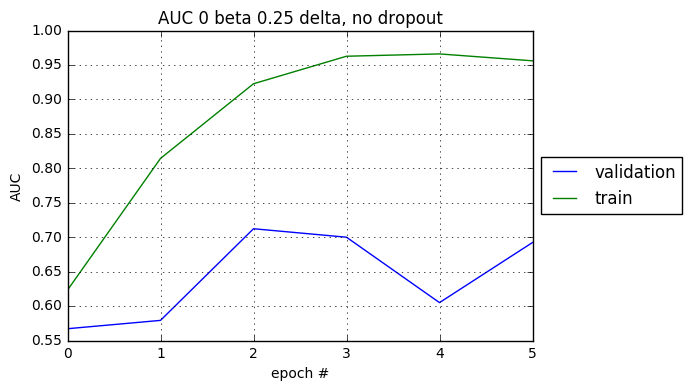

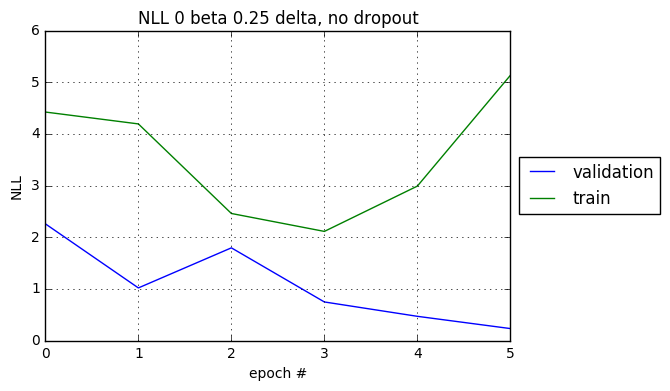

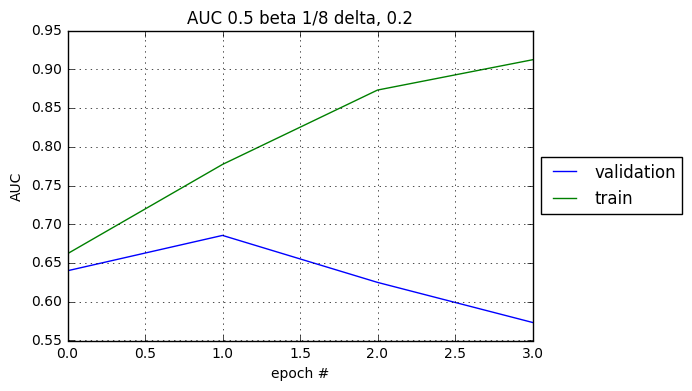

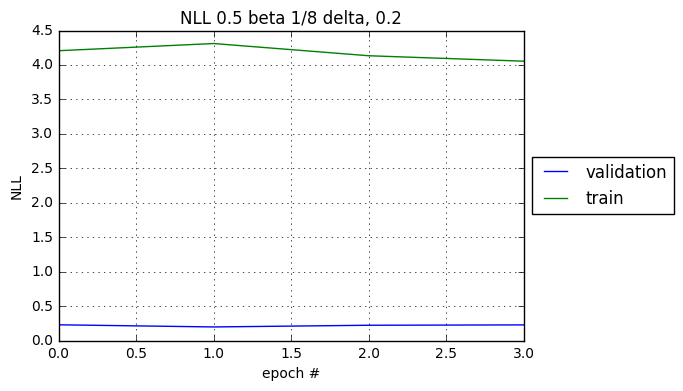

In [51]:
# 0 beta 0.1 delta, 0.4+0.2
auc_val = [0.53533, 0.51900, 0.4874, 0.5383, 0.52665, 0.56129]
nll_val = [1.4517, 1.05985, 0.61845, 0.4164, 0.3030, 0.2461]
auc_train = [0.5392, 0.58879, 0.6318883, 0.6953, 0.7653, 0.82735]
nll_train = [3.13513, 3.1507, 3.2682, 3.4128, 3.50666, 3.532964]
draw_line_plot([range(len(nll_val)), range(len(nll_val))],
               [auc_val, auc_train],
               "AUC 0 beta 0.1 delta, 0.4+0.2",
              "epoch #", "AUC", ["validation", "train"])
draw_line_plot([range(len(nll_val)), range(len(nll_val))],
               [nll_val, nll_train],
               "NLL 0 beta 0.1 delta, 0.4+0.2",
              "epoch #", "NLL", ["validation", "train"])


# 0 beta 0.1 delta, 0.3+0.1
auc_val = [0.5914, 0.64159]
nll_val = [1.281, 0.90811]
auc_train = [0.5394, 0.5894]
nll_train = [3.13587, 3.1537]

draw_line_plot([range(len(nll_val)), range(len(nll_val))],
               [auc_val, auc_train],
               "AUC 0 beta 0.1 delta, 0.3+0.1",
              "epoch #", "AUC", ["validation", "train"])
draw_line_plot([range(len(nll_val)), range(len(nll_val))],
               [nll_val, nll_train],
               "NLL 0 beta 0.1 delta, 0.3+0.1",
              "epoch #", "NLL", ["validation", "train"])



# 0 beta 0.25 delta, no dropout
auc_val = [0.5671, 0.5792, 0.71224, 0.69992, 0.6050, 0.692242]
nll_val = [2.258, 1.0177, 1.7934, 0.746, 0.468, 0.2309]
auc_train = [0.6232, 0.8143, 0.9227, 0.96264, 0.966, 0.95600]
nll_train = [4.4219, 4.192, 2.4585, 2.11143, 2.98855, 5.1325]


draw_line_plot([range(len(nll_val)), range(len(nll_val))],
               [auc_val, auc_train],
               "AUC 0 beta 0.25 delta, no dropout",
              "epoch #", "AUC", ["validation", "train"])
draw_line_plot([range(len(nll_val)), range(len(nll_val))],
               [nll_val, nll_train],
               "NLL 0 beta 0.25 delta, no dropout",
              "epoch #", "NLL", ["validation", "train"])


# 0.5 beta 1/8 delta, 0.2
auc_val = [0.640, 0.6856, 0.62499, 0.5733]
nll_val = [0.228, 0.19669, 0.2213, 0.2265]
auc_train = [0.662, 0.7772, 0.87315, 0.91224]
nll_train = [4.2065, 4.31090, 4.13369, 4.05451]


draw_line_plot([range(len(nll_val)), range(len(nll_val))],
               [auc_val, auc_train],
               "AUC 0.5 beta 1/8 delta, 0.2",
              "epoch #", "AUC", ["validation", "train"])
draw_line_plot([range(len(nll_val)), range(len(nll_val))],
               [nll_val, nll_train],
               "NLL 0.5 beta 1/8 delta, 0.2",
              "epoch #", "NLL", ["validation", "train"])
    
    

In [52]:
import json

In [72]:
date_set = set()
ctr = 0
with open("/Users/Melancardie/Dropbox/Documents/My Research/NYU/Sundararajan/hotel/data/cmu/review.txt") as f:
    content = f.readlines()
    for line in content:
        date_set.add(json.loads(line)["date"])
#parsed_json = json.loads(json_string)
#json_string

In [70]:
review_list[0]["date"]

u'December 17, 2012'

In [76]:
sorted(list(date_set))

[u'April 1, 2002',
 u'April 1, 2003',
 u'April 1, 2004',
 u'April 1, 2005',
 u'April 1, 2006',
 u'April 1, 2007',
 u'April 1, 2008',
 u'April 1, 2009',
 u'April 1, 2010',
 u'April 1, 2011',
 u'April 1, 2012',
 u'April 10, 2002',
 u'April 10, 2003',
 u'April 10, 2004',
 u'April 10, 2005',
 u'April 10, 2006',
 u'April 10, 2007',
 u'April 10, 2008',
 u'April 10, 2009',
 u'April 10, 2010',
 u'April 10, 2011',
 u'April 10, 2012',
 u'April 11, 2002',
 u'April 11, 2003',
 u'April 11, 2004',
 u'April 11, 2005',
 u'April 11, 2006',
 u'April 11, 2007',
 u'April 11, 2008',
 u'April 11, 2009',
 u'April 11, 2010',
 u'April 11, 2011',
 u'April 11, 2012',
 u'April 12, 2002',
 u'April 12, 2003',
 u'April 12, 2004',
 u'April 12, 2005',
 u'April 12, 2006',
 u'April 12, 2007',
 u'April 12, 2008',
 u'April 12, 2009',
 u'April 12, 2010',
 u'April 12, 2011',
 u'April 12, 2012',
 u'April 13, 2001',
 u'April 13, 2003',
 u'April 13, 2004',
 u'April 13, 2005',
 u'April 13, 2006',
 u'April 13, 2007',
 u'April 13